In [121]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind, pearsonr
from sklearn import set_config
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


set_config(transform_output="pandas")

df = pd.read_csv('data/train_data.csv')


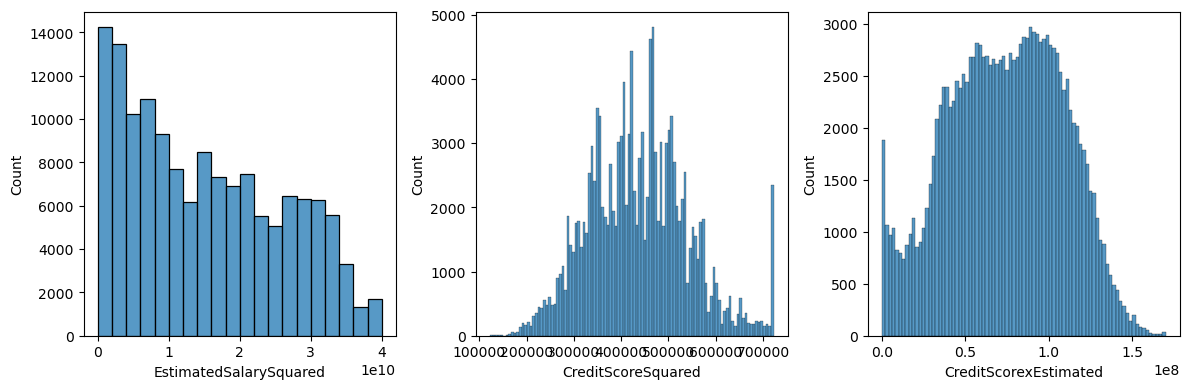

In [122]:
# link to Kaggle competition
# https://www.kaggle.com/competitions/mlpro-classification-bank-churn-2025

# Dataset
# Customer ID : Un identifiant pour chaque client
# Surname : Le nom de famille du client
# Credit Score : Une valeur numérique représentant le score de crédit du client
# Geography : Le pays où réside le client (France, Spain ou Germany)
# Gender : Le genre du client (Male or Female)
# Age : L’âge du client
# Tenure : Le nombre d’années pendant lesquelles le client est avec la banque
# Balance : Le solde du compte du client
# NumOfProducts : Le nombre de produits bancaires utilisés par le client (par exemple, compte d’épargne, carte de crédit)
# HasCrCard : Si le client possède une carte de crédit (1 = oui, 0 = non)
# IsActiveMember : Si le client est un membre actif (1 = oui, 0 = non)
# EstimatedSalary : Le salaire estimé du client
# Exited : Si le client a résilié (1 = oui, 0 = non)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


# split Balance in 2 columns
df["HasZeroBalance"] = (df["Balance"] == 0).astype(int)
df["BalanceCreditScoreRatio"] = df["Balance"] / df["CreditScore"]
df.head()

X_salary = df[["CreditScore", "EstimatedSalary"]]

polynomial_transform =  PolynomialFeatures(degree=2, include_bias=False)
results = polynomial_transform.fit_transform(X_salary)
results
df["EstimatedSalarySquared"] = results["EstimatedSalary^2"]
df["CreditScoreSquared"] = results["CreditScore^2"]
df["CreditScorexEstimated"] = results["CreditScore EstimatedSalary"]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df, x="EstimatedSalarySquared", bins=20, ax=ax[0])
sns.histplot(df, x="CreditScoreSquared", ax=ax[1])
sns.histplot(df, x="CreditScorexEstimated", ax=ax[2])
plt.tight_layout()
plt.show()


#### Encode categorical variables

In [123]:
column_transformer = ColumnTransformer(transformers=[
   ("Encoder OneHot", OneHotEncoder(sparse_output=False, drop="first"), ["Geography", "Gender"])
   ], 
   remainder="passthrough",
   verbose_feature_names_out=False)

pipeline = Pipeline(steps=[("Encoding", column_transformer)])
df = pipeline.fit_transform(df)
df.head()

,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,HasZeroBalance,BalanceCreditScoreRatio,EstimatedSalarySquared,CreditScoreSquared,CreditScorexEstimated
0,0.0,0.0,1.0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0,210.038341,2.598725e+10,393129.0,1.010759e+08
1,0.0,0.0,1.0,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29,0,1,0.000000,3.291296e+10,356409.0,1.083073e+08
2,0.0,0.0,1.0,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54,0,1,0.000000,1.017325e+10,524176.0,7.302448e+07
3,1.0,0.0,0.0,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45,1,0,178.849532,3.741090e+09,439569.0,4.055203e+07
4,0.0,0.0,0.0,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82,0,1,0.000000,1.076154e+10,393129.0,6.504361e+07


#### Balancing dataset

(143579, 19)
(226258, 19)


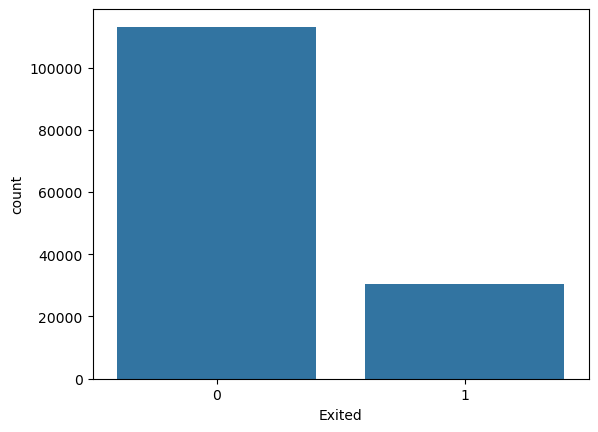

In [124]:
sns.countplot(df, x="Exited")

# Imbalanced data between exited and non exited clients

# Try rebalance by undersampling

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

under = RandomOverSampler()
X = df.drop(['Surname'], axis=1)
y = df["Exited"]
X_balanced,y_balanced=under.fit_resample(X,y)
print(X.shape)
print(X_balanced.shape)

#### Split dataset

In [125]:
train_set, test_set = train_test_split(X_balanced, test_size=0.2)
print(train_set.shape)
print(test_set.shape)

(181006, 19)
(45252, 19)


### Traitement des NaNs

In [126]:
df.isna().sum(axis = 0)
# Pas de NaN

Geography_Germany          0
Geography_Spain            0
Gender_Male                0
ID                         0
CustomerId                 0
Surname                    0
CreditScore                0
Age                        0
Tenure                     0
Balance                    0
NumOfProducts              0
HasCrCard                  0
IsActiveMember             0
EstimatedSalary            0
Exited                     0
HasZeroBalance             0
BalanceCreditScoreRatio    0
EstimatedSalarySquared     0
CreditScoreSquared         0
CreditScorexEstimated      0
dtype: int64

## Preprocessing

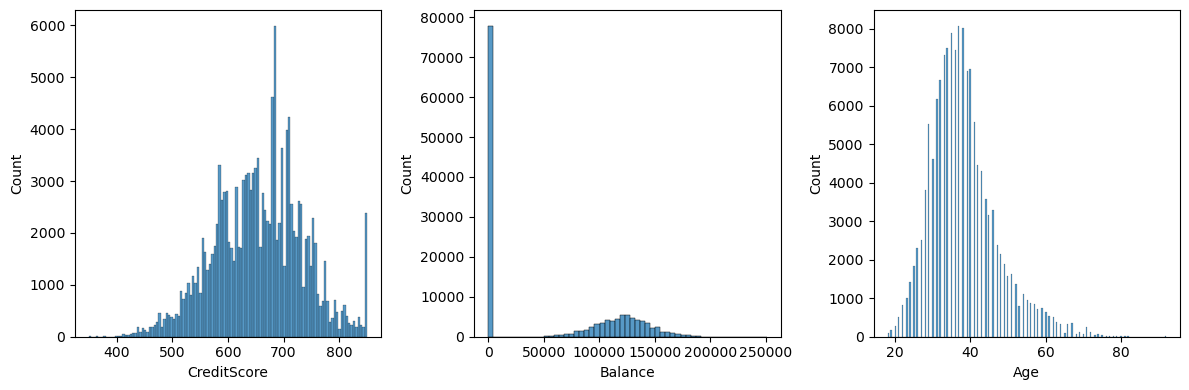

In [127]:
from pyparsing import C

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df, x="CreditScore", ax = ax[0])
sns.histplot(df, x="Balance", ax = ax[1])
sns.histplot(df, x="Age", ax = ax[2])
plt.tight_layout()
plt.show()


In [128]:
column_transformer = ColumnTransformer(transformers=[
   #("Encoder OneHot", OneHotEncoder(sparse_output=False, drop="first"), ["Geography", "Gender"]),
   ("MinMaxScaler", MinMaxScaler(), ['Tenure', 'NumOfProducts', 'Balance', 'EstimatedSalary', 'EstimatedSalarySquared', 'BalanceCreditScoreRatio']),
   ("StandardScaler", StandardScaler(), ['CreditScore', 'Age', "CreditScorexEstimated"])], 
   remainder="passthrough",
   verbose_feature_names_out=False)

# remove age outliers
train_set = train_set.query('Age < 90')

pipeline = Pipeline(steps=[("Encoding + Normalisation", column_transformer)])
training_df = pipeline.fit_transform(train_set)
training_df


,Tenure,NumOfProducts,Balance,EstimatedSalary,EstimatedSalarySquared,BalanceCreditScoreRatio,CreditScore,Age,CreditScorexEstimated,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,HasCrCard,IsActiveMember,Exited,HasZeroBalance,CreditScoreSquared
171243,0.5,0.000000,0.000000,0.178003,0.031702,0.000000,0.225319,-0.562722,-1.454953,0.0,0.0,1.0,86585,15705113,1.0,0.0,1,1,452929.0
57288,0.1,0.333333,0.000000,0.322949,0.104321,0.000000,0.733888,-0.669583,-0.811898,0.0,0.0,1.0,92370,15630195,1.0,0.0,0,1,509796.0
25812,0.9,0.333333,0.000000,0.517796,0.268142,0.000000,0.299744,0.078440,-0.109617,0.0,0.0,1.0,149380,15780088,1.0,1.0,0,1,461041.0
19877,0.8,0.000000,0.476259,0.659145,0.434498,0.399677,-0.233634,0.826464,0.282919,1.0,0.0,1.0,7412,15693817,1.0,1.0,1,0,404496.0
217665,0.7,0.000000,0.599283,0.314200,0.098747,0.482439,0.101278,-1.631327,-0.941180,1.0,0.0,0.0,73988,15661591,1.0,0.0,1,0,439569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103177,1.0,0.000000,0.423449,0.833413,0.694593,0.334333,0.262532,-0.242141,1.119726,0.0,0.0,1.0,77325,15691952,1.0,1.0,0,0,456976.0
207156,0.5,0.333333,0.421614,0.832573,0.693194,0.308682,0.919950,-0.776443,1.372565,1.0,0.0,0.0,28465,15795975,0.0,0.0,1,0,531441.0
114847,0.4,0.333333,0.000000,0.629356,0.396116,0.000000,0.547826,-1.310746,0.403108,0.0,0.0,1.0,34536,15654862,0.0,0.0,0,1,488601.0
79237,0.9,0.000000,0.758186,0.487529,0.237713,0.589896,0.386573,1.681347,-0.209092,0.0,0.0,0.0,70114,15682435,1.0,0.0,1,0,470596.0


### Transform test data set

In [129]:
df_test = pipeline.transform(test_set)
df_test

,Tenure,NumOfProducts,Balance,EstimatedSalary,EstimatedSalarySquared,BalanceCreditScoreRatio,CreditScore,Age,CreditScorexEstimated,Geography_Germany,Geography_Spain,Gender_Male,ID,CustomerId,HasCrCard,IsActiveMember,Exited,HasZeroBalance,CreditScoreSquared
15143,0.6,0.333333,0.000000,0.700704,0.491010,0.000000,1.192841,-0.349001,0.904076,0.0,0.0,1.0,112665,15591150,1.0,0.0,0,1,564001.0
151089,0.7,0.000000,0.527730,0.513136,0.263337,0.411794,0.361765,0.185301,-0.113090,1.0,0.0,1.0,106407,15601263,1.0,1.0,1,0,467856.0
12182,0.1,0.000000,0.373926,0.418485,0.175158,0.298767,0.163299,-0.990164,-0.527727,1.0,0.0,0.0,1896,15719377,1.0,1.0,0,0,446224.0
84495,0.4,0.000000,0.360880,0.306176,0.093768,0.244123,1.664198,0.933324,-0.748103,1.0,0.0,0.0,17495,15767432,1.0,0.0,1,0,622521.0
53853,0.6,0.000000,0.283941,0.514536,0.264776,0.259501,-0.878648,-0.135281,-0.406212,1.0,0.0,0.0,61956,15691808,1.0,1.0,0,0,341056.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46672,0.6,0.000000,0.501708,0.601900,0.362312,0.450805,-0.754607,0.292161,-0.075140,1.0,0.0,1.0,113267,15675787,1.0,0.0,1,0,352836.0
79471,0.1,0.000000,0.420885,0.469907,0.220841,0.308572,0.907546,-0.669583,-0.164691,1.0,0.0,1.0,14329,15631159,0.0,0.0,0,0,529984.0
199053,0.1,0.333333,0.490036,0.901287,0.812328,0.364782,0.771101,0.719603,1.600529,0.0,0.0,0.0,158482,15706534,1.0,0.0,1,0,514089.0
201169,0.5,0.333333,0.571067,0.157861,0.024936,0.518362,-0.829032,2.215650,-1.611543,1.0,0.0,0.0,117368,15636330,1.0,0.0,1,0,345744.0


# Training + Evaluation

In [130]:
from sklearn.ensemble import GradientBoostingClassifier


predictions_columns = ["Geography_Germany", "Geography_Spain", "Gender_Male", "Tenure", "IsActiveMember", "EstimatedSalary", "NumOfProducts", "Age", "Balance", "HasCrCard"]
X_train = training_df[predictions_columns]
y_train = training_df["Exited"]

# model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier(learning_rate=0.25, n_estimators=200)
# model.fit(X_train, y_train)


# param_grid = {
#    "n_neighbors": range(8, 11),
#    "weights": ['uniform', 'distance'],
#    #"metric": ["euclidean"]
# }

# param_grid_random_forest = {
#    "criterion": ["gini", "entropy", "log_loss"]
# }

# param_grid_gradient_boosting = {
#    #"loss" : ['log_loss', 'exponential'],
#    'max_depth': [3, 5, 7],
#    'min_samples_split': [2, 5, 10]
# }


# grid_search = GridSearchCV(estimator=model, param_grid=param_grid_gradient_boosting, cv=5, scoring="f1")
# grid_search.fit(X_train, y_train)
# params = grid_search.cv_results_["params"]
# scores = grid_search.cv_results_["mean_test_score"]

# grid_search_results = pd.DataFrame(params)
# grid_search_results["score"] = scores
# grid_search_results



# print(f"Scores de validation croisée: {cv_scores}")
# print(f"Moyenne des scores de validation croisée: {cv_scores.mean()}")

In [131]:
# grid_search_heatmap = grid_search_results.pivot(index='n_estimators', columns='learning_rate', values="score")
# sns.heatmap(grid_search_heatmap, annot=True, fmt=".3f", cmap="viridis")
# plt.show()
# print(f"Meilleurs paramètres : {grid_search.best_params_}")
# print(f"Meilleurs score : {grid_search.best_score_}")

In [132]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC

predictions_columns = [
   "Geography_Germany",
   "Geography_Spain",
   "Gender_Male", 
   "Tenure", 
   "IsActiveMember", 
   "NumOfProducts", 
   "HasZeroBalance",
   "Age",
   "HasCrCard",
   "CreditScore",
   "EstimatedSalary"]
X_train = training_df[predictions_columns]
y_train = training_df["Exited"]

# model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=250, max_depth=3, min_samples_split=3)
# model = KNeighborsClassifier(n_neighbors=9)
model = RandomForestClassifier(criterion="gini")
# model.fit(X_train, y_train, sample_weight=[2 if y == 1 else 1 for y in y_train])
model.fit(X_train, y_train)

X_test = df_test[predictions_columns]
predictions = model.predict(X_test)
predictions

results = pd.DataFrame({
   "ID": test_set["ID"],
   "Exited": predictions
})

results = results.set_index("ID")

sorted_y = df_test[["ID", "Exited"]].sort_values("ID")
sorted_y

sorted_y_pred = results.sort_values("ID")
sorted_y_pred

print(f"accuracy_score = {accuracy_score(sorted_y["Exited"], sorted_y_pred["Exited"])}")
print(f"precision_score = {precision_score(sorted_y["Exited"], sorted_y_pred["Exited"])}")
print(f"recall_score = {recall_score(sorted_y["Exited"], sorted_y_pred["Exited"])}")
print(f"f1_score = {f1_score(sorted_y["Exited"], sorted_y_pred["Exited"])}")

accuracy_score = 0.9408202952355696
precision_score = 0.9069172688154583
recall_score = 0.9830590513068732
f1_score = 0.9434543918918918
